In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

df = pd.read_csv("./cic_ids_smote03_pca25.csv")
#df = pd.read_csv("/Users/anchanghun/Downloads/CIC-Dataset/cleaned_improved_cicids2017.csv")

In [3]:
X_train =pd.read_csv("D:/dataset/0219_Paper_Dataset/train_pca.csv")
X_test =pd.read_csv("D:/dataset/0219_Paper_Dataset/test_pca.csv")

In [4]:
X_train.shape, X_test.shape

((2296135, 26), (405464, 26))

In [5]:
y_train = X_train['label']
X_train = X_train.drop(labels='label',axis=1)

In [6]:
y_test = X_test['label']
X_test = X_test.drop(labels='label',axis=1)

In [7]:
X_train.shape, X_test.shape

((2296135, 25), (405464, 25))

In [8]:
y_train.shape, y_test.shape

((2296135,), (405464,))

In [9]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

# ✅ 클래스 개수 (정상 + 공격 유형 개수)
num_classes = 9  # 정상(1) + 8개 공격

# ✅ 잠재 차원 및 중간 차원 설정
latent_dim = 10
inter_dim = 20

# ✅ 샘플링 함수 (재매개변수화 트릭 사용)
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * K.clip(z_log_sigma, -10, 10)) * epsilon

# ✅ CVAE 손실 함수 (Gaussian MLP & Bernoulli MLP 반영)
def cvae_loss(x, x_decoded_mean, z_mean, z_log_sigma, y_true, y_pred):
    # Reconstruction Loss (Gaussian MLP 적용)
    reconstruction_loss = K.mean(K.square(x - x_decoded_mean) + 1e-10)  # NaN 방지
    
    # KL Divergence (잠재 공간 학습 - Gaussian MLP)
    kl_loss = -0.5 * K.sum(1 + K.clip(z_log_sigma, -10, 10) - K.square(z_mean) - K.exp(K.clip(z_log_sigma, -10, 10)), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 손실 가중치 적용

    # Classification Loss (Bernoulli MLP 적용)
    classification_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)  # 다중 분류
    
    # 총 손실 (Gaussian + Bernoulli)
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted + classification_loss)
    return total_loss

# ✅ CVAE 모델 정의 (Gaussian MLP + Bernoulli MLP)
def cvae(X, y):
    features = X.shape[1]  # 특징 수
    input_x = Input(shape=(features,), name='InputFeatures')
    input_y = Input(shape=(num_classes,), name='InputLabels')  # 라벨 추가

    # CNN 기반 인코더
    reshaped_input = layers.Reshape((features, 1))(input_x)
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Concatenate()([h, input_y])  # 라벨과 결합
    h = layers.Dense(inter_dim, activation='relu')(h)

    # Gaussian MLP (잠재 공간)
    z_mean = layers.Dense(latent_dim, name='z_mean')(h)
    z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(h)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_sigma])

    # 디코더 (Gaussian MLP)
    decoder_input = layers.Concatenate()([z, input_y])  # 잠재 벡터 + 라벨
    decoder1 = layers.Dense(features * inter_dim)(decoder_input)
    decoder1 = layers.Reshape((features, inter_dim))(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Flatten()(decoder1)
    x_decoded_mean = layers.Dense(features, activation='sigmoid', name='ReconstructedOutput')(decoder1)  # 최종 복원

    # Bernoulli MLP (다중 분류)
    classification_output = layers.Dense(num_classes, activation='softmax', name='ClassificationOutput')(h)

    # 모델 생성
    model = Model([input_x, input_y], [x_decoded_mean, classification_output])
    model.add_loss(cvae_loss(input_x, x_decoded_mean, z_mean, z_log_sigma, input_y, classification_output))

    return model

# ✅ CVAE 학습 (정상 + 여러 공격 데이터 포함)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)  # 라벨 원핫 인코딩
model = cvae(X_train, y_train_onehot)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([X_train, y_train_onehot], [X_train, y_train_onehot],  # Reconstruction + Classification
                    shuffle=True, epochs=50, validation_split=0.1, batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/50
64579/64579 [==============================] - 653s 10ms/step - loss: 2.7085 - ReconstructedOutput_accuracy: 0.8919 - ClassificationOutput_accuracy: 0.9988 - val_loss: 0.7198 - val_ReconstructedOutput_accuracy: 0.9956 - val_ClassificationOutput_accuracy: 0.9997
Epoch 2/50
64579/64579 [==============================] - 645s 10ms/step - loss: 2.6838 - ReconstructedOutput_accuracy: 0.9027 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.7170 - val_ReconstructedOutput_accuracy: 0.9934 - val_ClassificationOutput_accuracy: 0.9997
Epoch 3/50
64579/64579 [==============================] - 666s 10ms/step - loss: 2.6827 - ReconstructedOutput_accuracy: 0.9048 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.7145 - val_ReconstructedOutput_accuracy: 0.9898 - val_ClassificationOutput_accuracy: 0.9997
Epoch 4/50
64579/64579 [==============================] - 680s 11ms/step - loss: 2.6819 - ReconstructedOutput_accuracy: 0.9042 - ClassificationOutput_accuracy: 1.0000 - val_loss: 0.

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputFeatures (InputLayer)     [(None, 25)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 25, 1)        0           ['InputFeatures[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 25, 64)       256         ['reshape[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 25, 32)       6176        ['conv1d[0][0]']                 
                                                                                              

 a)                                                                                               
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 9)            0           ['InputLabels[0][0]']            
                                                                                                  
 tf.convert_to_tensor (TFOpLamb  (None, 9)           0           ['ClassificationOutput[0][0]']   
 da)                                                                                              
                                                                                                  
 tf.__oper

In [13]:
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)  # 라벨 원핫 인코딩

In [14]:
# ✅ 모델 예측 (CVAE는 2개 출력을 반환)
X_reconstructed, y_pred = model.predict([X_test, y_test_onehot])

# ✅ 복원 오류 (MSE) 계산 (X_reconstructed만 사용)
reconstruction_errors = np.mean(np.square(X_test - X_reconstructed), axis=1)

# ✅ error_df 생성 (실제 라벨 포함)
error_df = pd.DataFrame({
    'reconstruction_error': reconstruction_errors,
    'true_class': y_test  # 실제 라벨
})

# ✅ DataFrame 출력
print(error_df.head())


12671/12671 [==============================] - 56s 4ms/step
   reconstruction_error  true_class
0            148.083457           0
1              1.519856           3
2              0.184491           0
3              0.631370           0
4              0.558209           0


In [16]:
error_df['true_class'].value_counts()

0    318909
7     31813
3     31694
1     19029
2      1513
6       794
5       772
8       592
4       348
Name: true_class, dtype: int64


✅ 수정된 클래스별 Threshold 값:
   Class  Threshold
0      0  27.539955
1      3   4.601310
2      2   8.336392
3      7   9.308744
4      1   5.262301
5      4   8.824176
6      8   0.943507
7      6   0.847960
8      5  13.402010
Classification Report:


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.8975    0.8589    0.8778    318909
           1     0.0000    0.0000    0.0000     19029
           2     0.0000    0.0000    0.0000      1513
           3     0.0000    0.0000    0.0000     31694
           4     0.0000    0.0000    0.0000       348
           5     0.0000    0.0000    0.0000       772
           6     0.0001    0.0101    0.0002       794
           7     0.0000    0.0000    0.0000     31813
           8     0.0000    0.0000    0.0000       592

    accuracy                         0.6756    405464
   macro avg     0.0997    0.0966    0.0975    405464
weighted avg     0.7059    0.6756    0.6904    405464



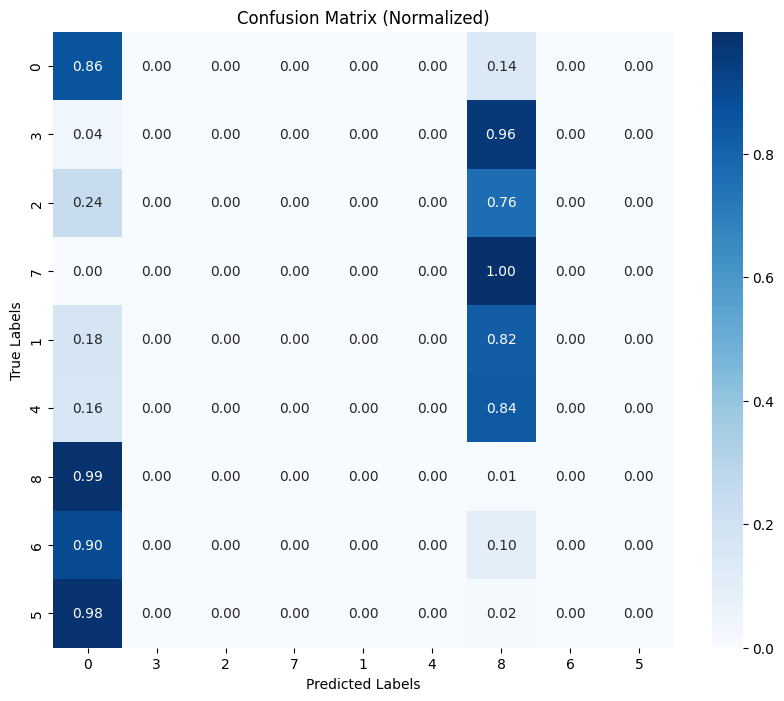

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
from sklearn.metrics import classification_report, confusion_matrix

# ✅ EVT를 활용하여 다중 클래스 분류하는 함수 (공격 유형별 적용)
def calculate_evt_thresholds_per_attack(error_df, tail_fraction=0.1, quantile=0.95):
    thresholds = {}

    for attack_class in error_df['true_class'].unique():
        errors = error_df[error_df['true_class'] == attack_class]['reconstruction_error'].values
        errors = np.sort(errors)

        if len(errors) < 10:
            Q3 = np.percentile(errors, 75)
            IQR = Q3 - np.percentile(errors, 25)
            thresholds[attack_class] = Q3 + 1.5 * IQR
        else:
            threshold_idx = int(len(errors) * (1 - tail_fraction))
            threshold_value = errors[threshold_idx]

            # EVT 적용 (Generalized Pareto Distribution)
            excesses = errors[threshold_idx:] - threshold_value
            shape, loc, scale = genpareto.fit(excesses)
            evt_threshold = threshold_value + genpareto.ppf(quantile, shape, loc=loc, scale=scale)

            # 최대 99th Percentile 제한 적용
            thresholds[attack_class] = min(evt_threshold, np.percentile(errors, 99))

    return thresholds

# ✅ 다중 클래스 EVT Threshold 계산
attack_thresholds = calculate_evt_thresholds_per_attack(error_df)
error_df['threshold'] = error_df['true_class'].map(attack_thresholds)

def predict_attack_class(error, thresholds):
    # Threshold를 낮은 값부터 정렬 (가장 먼저 초과하는 클래스 찾기)
    sorted_thresholds = sorted(thresholds.items(), key=lambda x: x[1])

    for attack_class, threshold in sorted_thresholds:
        if error > threshold:
            return attack_class  # 가장 먼저 초과한 클래스 선택

    return 0  # 정상(0)으로 분류


# ✅ 각 샘플에 대해 EVT를 기반으로 다중 클래스 예측 수행
error_df['pred_class'] = error_df['reconstruction_error'].apply(lambda x: predict_attack_class(x, attack_thresholds))

# ✅ 적용된 새로운 Threshold 확인
print("\n✅ 수정된 클래스별 Threshold 값:")
print(pd.DataFrame(attack_thresholds.items(), columns=["Class", "Threshold"]))

# ✅ 성능 평가 및 시각화 함수
def evaluate_and_plot(y_true, y_pred, class_labels):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()

# ✅ EVT 기반 다중 클래스 분류 성능 평가
evaluate_and_plot(error_df['true_class'].values, error_df['pred_class'].values, class_labels=error_df['true_class'].unique())


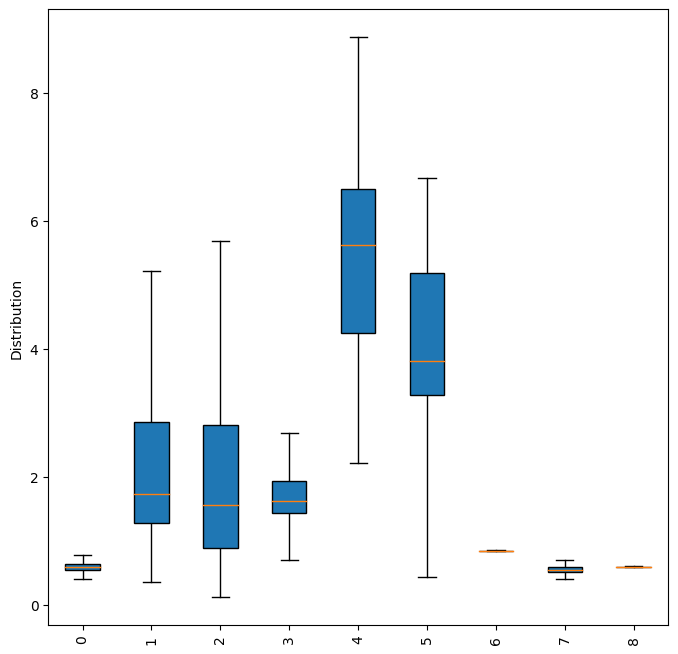

In [22]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()



✅ 각 공격 유형별 EVT Threshold 값:
   Attack Class  Threshold
0             3   4.601310
1             2   8.336392
2             7   9.308744
3             1   5.262301
4             4   8.824176
5             8   0.943507
6             6   0.847960
7             5  13.402010
Classification Report:


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.7852    0.9900    0.8758    318909
           1     0.0000    0.0000    0.0000     19029
           2     0.0000    0.0000    0.0000      1513
           3     0.0000    0.0000    0.0000     31694
           4     0.0000    0.0000    0.0000       348
           5     0.0000    0.0000    0.0000       772
           6     0.0000    0.0000    0.0000       794
           7     0.0000    0.0000    0.0000     31813
           8     0.0000    0.0000    0.0000       592

    accuracy                         0.7787    405464
   macro avg     0.0872    0.1100    0.0973    405464
weighted avg     0.6176    0.7787    0.6888    405464



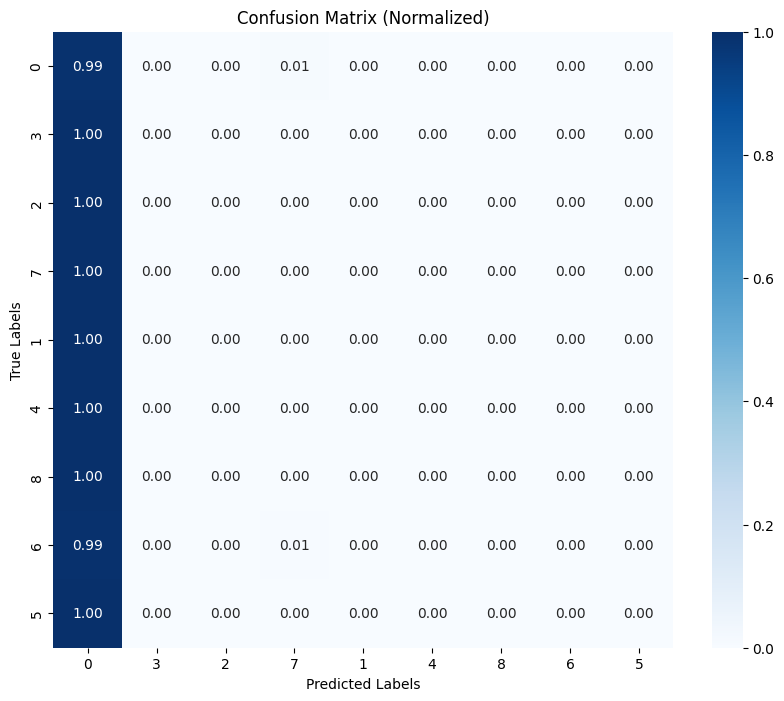

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 각 공격 유형을 정상(0)과 개별적으로 비교하여 EVT Threshold 적용
def calculate_evt_threshold_per_attack(error_df, normal_class=0, tail_fraction=0.1, quantile=0.95):
    thresholds = {}

    normal_errors = error_df[error_df['true_class'] == normal_class]['reconstruction_error'].values
    normal_errors = np.sort(normal_errors)
    normal_threshold_idx = int(len(normal_errors) * (1 - tail_fraction))
    normal_threshold_value = normal_errors[normal_threshold_idx]

    for attack_class in error_df['true_class'].unique():
        if attack_class == normal_class:
            continue  # 정상 데이터는 제외하고 각 공격 유형만 비교

        attack_errors = error_df[error_df['true_class'] == attack_class]['reconstruction_error'].values
        attack_errors = np.sort(attack_errors)

        if len(attack_errors) < 10:
            Q3 = np.percentile(attack_errors, 75)
            IQR = Q3 - np.percentile(attack_errors, 25)
            thresholds[attack_class] = Q3 + 1.5 * IQR
        else:
            threshold_idx = int(len(attack_errors) * (1 - tail_fraction))
            threshold_value = attack_errors[threshold_idx]

            # EVT 적용
            excesses = attack_errors[threshold_idx:] - threshold_value
            shape, loc, scale = genpareto.fit(excesses)
            evt_threshold = threshold_value + genpareto.ppf(quantile, shape, loc=loc, scale=scale)

            # 최대 99th Percentile 제한 적용
            thresholds[attack_class] = min(evt_threshold, np.percentile(attack_errors, 99))

    return thresholds

# ✅ 정상(0)과 개별 공격 유형 비교하여 Threshold 설정
attack_thresholds = calculate_evt_threshold_per_attack(error_df)
error_df['threshold'] = error_df['true_class'].map(attack_thresholds)

# ✅ 정상(0)과 개별 공격을 비교하여 이상 탐지 수행
def predict_attack_class(error, thresholds, normal_threshold):
    for attack_class, threshold in thresholds.items():
        if error > normal_threshold and error > threshold:
            return attack_class  # 정상보다 높은 reconstruction error를 가진 첫 번째 공격 유형 선택
    return 0  # 정상(0)으로 분류

# ✅ 각 샘플에 대해 EVT 기반 1:1 비교 예측 수행
normal_threshold = np.percentile(error_df[error_df['true_class'] == 0]['reconstruction_error'], 99)  # 정상 데이터의 99% 이상값
error_df['pred_class'] = error_df['reconstruction_error'].apply(lambda x: predict_attack_class(x, attack_thresholds, normal_threshold))

# ✅ 적용된 새로운 Threshold 확인
print("\n✅ 각 공격 유형별 EVT Threshold 값:")
print(pd.DataFrame(attack_thresholds.items(), columns=["Attack Class", "Threshold"]))

# ✅ 성능 평가 및 시각화 함수
def evaluate_and_plot(y_true, y_pred, class_labels):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()

# ✅ EVT 기반 다중 클래스 분류 성능 평가
evaluate_and_plot(error_df['true_class'].values, error_df['pred_class'].values, class_labels=error_df['true_class'].unique())



✅ 수정된 클래스별 Threshold 값:
   Class  Threshold
0      0  27.539955
1      3   4.601310
2      2   8.336392
3      7   9.308744
4      1   5.262301
5      4   8.824176
6      8   0.943507
7      6   0.847960
8      5  13.402010
12671/12671 [==============================] - 67s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    318909
           1     1.0000    1.0000    1.0000     19029
           2     1.0000    1.0000    1.0000      1513
           3     1.0000    1.0000    1.0000     31694
           4     1.0000    1.0000    1.0000       348
           5     1.0000    1.0000    1.0000       772
           6     1.0000    1.0000    1.0000       794
           7     1.0000    0.9999    1.0000     31813
           8     1.0000    1.0000    1.0000       592

    accuracy                         1.0000    405464
   macro avg     1.0000    1.0000    1.0000    405464
weighted avg     1.0000    1.0000    1.000

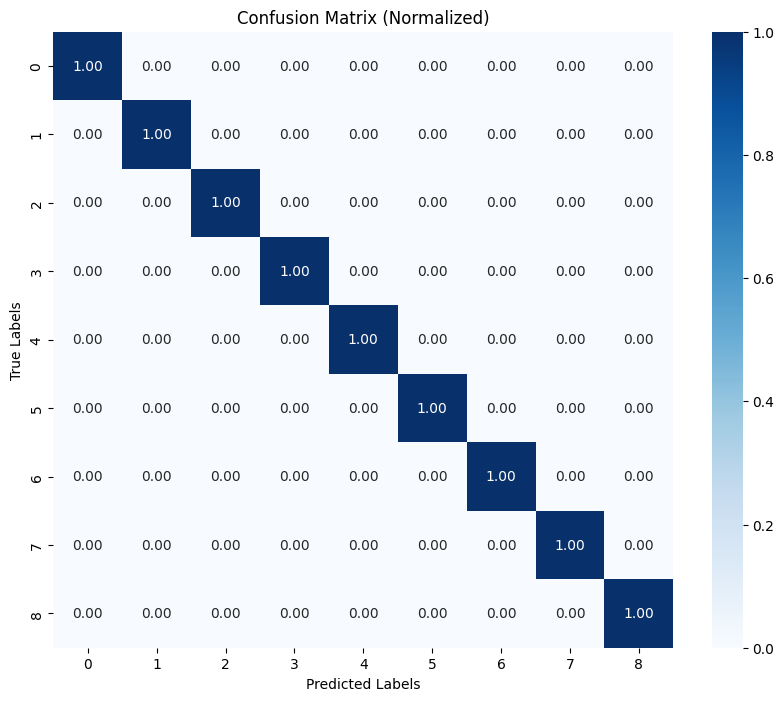

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 클래스별 EVT Threshold 적용 함수 (중복 제거 후 최적화)
def calculate_evt_threshold_per_class(error_df, tail_fraction=0.1, quantile=0.95):
    thresholds = {}
    
    for cls in error_df['true_class'].unique():
        errors = error_df[error_df['true_class'] == cls]['reconstruction_error'].values
        errors = np.sort(errors)

        if len(errors) < 10:
            Q3 = np.percentile(errors, 75)
            IQR = Q3 - np.percentile(errors, 25)
            thresholds[cls] = Q3 + 1.5 * IQR
        else:
            median_value = np.median(errors)
            threshold_idx = int(len(errors) * (1 - tail_fraction))
            threshold_value = errors[threshold_idx]

            # EVT 적용
            excesses = errors[threshold_idx:] - threshold_value
            shape, loc, scale = genpareto.fit(excesses)
            evt_threshold = threshold_value + genpareto.ppf(quantile, shape, loc=loc, scale=scale)

            # 최대 99th Percentile 제한 적용
            thresholds[cls] = min(evt_threshold, np.percentile(errors, 99))

    return thresholds

# ✅ 새로운 Threshold 계산 적용
class_thresholds = calculate_evt_threshold_per_class(error_df)
error_df['threshold'] = error_df['true_class'].map(class_thresholds)
error_df['pred_class'] = (error_df['reconstruction_error'] > error_df['threshold']).astype(int)

print("\n✅ 수정된 클래스별 Threshold 값:")
print(pd.DataFrame(class_thresholds.items(), columns=["Class", "Threshold"]))

# ✅ 성능 평가 및 시각화 함수 (중복 제거)
def evaluate_and_plot(y_true, y_pred, class_labels):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix (Normalized)")
    plt.show()

# ✅ 모델 예측 및 평가
_, y_pred_probs = model.predict([X_test, y_test_onehot])
y_pred = np.argmax(y_pred_probs, axis=1)

evaluate_and_plot(error_df['true_class'].values, y_pred, class_labels=range(9))


In [17]:
import numpy as np
import pandas as pd
from scipy.stats import genpareto

# ✅ 클래스별 EVT Threshold 적용 함수 (수정된 버전)
def calculate_evt_threshold_per_class(error_df, tail_fraction=0.1, quantile=0.95):
    thresholds = {}
    
    for cls in error_df['true_class'].unique():
        errors = error_df[error_df['true_class'] == cls]['reconstruction_error'].values
        
        if len(errors) < 10:
            # 샘플 수 부족 시, 기본 IQR 방식 사용
            Q1 = np.percentile(errors, 25)
            Q3 = np.percentile(errors, 75)
            IQR = Q3 - Q1
            thresholds[cls] = Q3 + 1.5 * IQR
        else:
            # ✅ median(class_errors) 기준으로 EVT 적용
            median_value = np.median(errors)
            errors = np.sort(errors)
            threshold_idx = int(len(errors) * (1 - tail_fraction))
            threshold_value = errors[threshold_idx]

            # ✅ Tail 부분 데이터 선택
            excesses = errors[threshold_idx:] - threshold_value

            # ✅ EVT 적용
            shape, loc, scale = genpareto.fit(excesses)
            evt_threshold = threshold_value + genpareto.ppf(quantile, shape, loc=loc, scale=scale)

            # ✅ Threshold가 이상할 경우 (클래스별 차이가 너무 큰 경우) 자동 조정
            max_threshold = np.percentile(errors, 99)  # 최대 99th Percentile 제한
            thresholds[cls] = min(evt_threshold, max_threshold)  # 둘 중 작은 값 적용

    return thresholds

# ✅ 새로운 Threshold 계산 적용
class_thresholds = calculate_evt_threshold_per_class(error_df)
error_df['threshold'] = error_df['true_class'].map(class_thresholds)
error_df['pred_class'] = (error_df['reconstruction_error'] > error_df['threshold']).astype(int)

# ✅ 적용된 새로운 Threshold 확인
print("\n✅ 수정된 클래스별 Threshold 값:")
print(pd.DataFrame(class_thresholds.items(), columns=["Class", "Threshold"]))



✅ 수정된 클래스별 Threshold 값:
   Class  Threshold
0      0  27.539955
1      3   4.601310
2      2   8.336392
3      7   9.308744
4      1   5.262301
5      4   8.824176
6      8   0.943507
7      6   0.847960
8      5  13.402010


12671/12671 [==============================] - 59s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    318909
           1     1.0000    1.0000    1.0000     19029
           2     1.0000    1.0000    1.0000      1513
           3     1.0000    1.0000    1.0000     31694
           4     1.0000    1.0000    1.0000       348
           5     1.0000    1.0000    1.0000       772
           6     1.0000    1.0000    1.0000       794
           7     1.0000    0.9999    1.0000     31813
           8     1.0000    1.0000    1.0000       592

    accuracy                         1.0000    405464
   macro avg     1.0000    1.0000    1.0000    405464
weighted avg     1.0000    1.0000    1.0000    405464



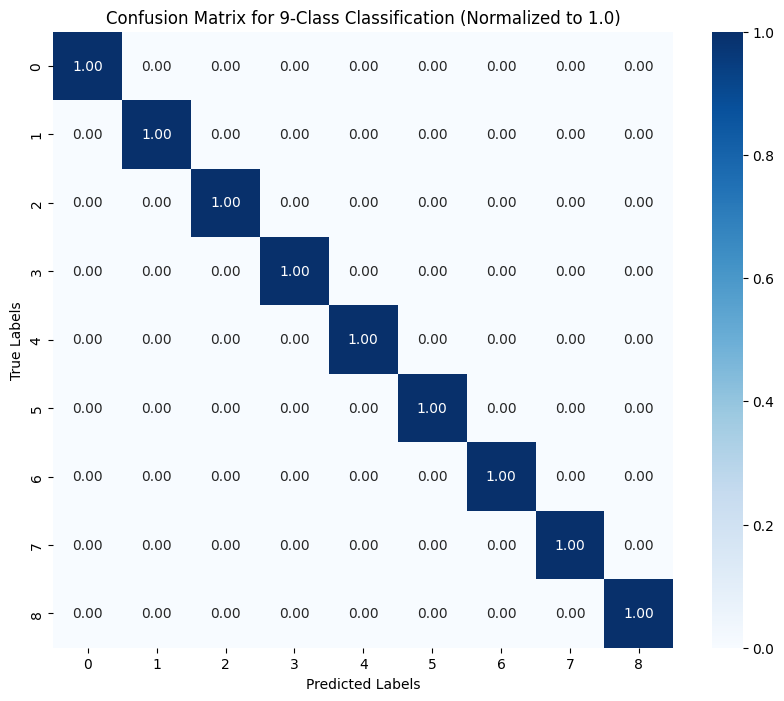

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ✅ 실제 라벨과 예측 라벨을 준비
y_true = error_df['true_class'].values  # 실제 라벨

# ✅ y_pred는 CVAE의 다중 클래스 분류 네트워크 출력값이어야 함
_, y_pred_probs = model.predict([X_test, y_test_onehot])  # 다중 클래스 확률 출력
y_pred = np.argmax(y_pred_probs, axis=1)  # 가장 높은 확률을 가진 클래스로 예측

# ✅ 성능 평가 (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ✅ 혼동 행렬 생성 (Count 기반)
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ 1.0 기준 정규화 (각 행을 합이 1.0이 되도록 변환)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)

# ✅ 혼동 행렬 시각화 (비율을 소수점 2자리까지 출력)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for 9-Class Classification (Normalized to 1.0)")
plt.show()


In [20]:
overlap = np.sum(np.isin(X_test, X_train).all(axis=1))
print(f"Number of overlapping samples: {overlap}")

Number of overlapping samples: 37386


In [21]:
print(np.unique(y_pred, return_counts=True))  # 예측된 라벨의 분포 확인


(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64), array([159258,  15848,  16025,  15989,  15937,  16072,  15957,  15889,
        16043], dtype=int64))


In [22]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (2583154, 25) Test shape: (287018, 25)


In [23]:
print("y_test unique values:", np.unique(y_test))
print("y_test_onehot shape:", y_test_onehot.shape)
print("Sample y_test_onehot:", y_test_onehot[:5])  # 일부 샘플 출력


y_test unique values: [0 1 2 3 4 5 6 7 8]
y_test_onehot shape: (287018, 9)
Sample y_test_onehot: [[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
# ✅ 예측된 클래스 확률 출력
print("Sample of y_pred_probs:\n", y_pred_probs[:5])

# ✅ 예측된 클래스의 분포 확인
unique_classes, class_counts = np.unique(y_pred, return_counts=True)
print("Predicted class distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")


Sample of y_pred_probs:
 [[4.19818763e-10 1.00000000e+00 6.37817490e-12 9.85933374e-21
  8.35109601e-26 2.85505133e-33 1.79881478e-37 0.00000000e+00
  3.34196584e-28]
 [1.00000000e+00 3.92215644e-12 8.27987418e-13 7.26229047e-25
  2.42683217e-12 1.01907725e-16 4.20134752e-31 8.45946047e-28
  2.88380332e-20]
 [1.00000000e+00 1.66353637e-22 4.09487170e-25 4.80541720e-23
  2.20228523e-11 2.22714964e-14 0.00000000e+00 4.85172748e-29
  6.98857731e-26]
 [1.00000000e+00 4.29341376e-20 1.14638734e-23 1.56655787e-27
  1.88749461e-22 1.26455003e-19 0.00000000e+00 6.88371880e-34
  8.81151552e-38]
 [1.00000000e+00 1.63733925e-15 3.34569643e-17 1.17883379e-27
  1.03257181e-12 2.41769409e-19 1.06357845e-35 1.06364688e-36
  5.33237143e-18]]
Predicted class distribution:
Class 0: 159258 samples
Class 1: 15848 samples
Class 2: 16025 samples
Class 3: 15989 samples
Class 4: 15937 samples
Class 5: 16072 samples
Class 6: 15957 samples
Class 7: 15889 samples
Class 8: 16043 samples
